In [163]:
import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, log_loss
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# %load ../src/weather_data_clean.py
import pandas as pd

def clean_weather_data(filename):
    """Take ASOS weather data file for Stampede pass and clean it ready for input to model.
    Input: txt file
    Output: pandas dataframe
    """
    data = pd.read_csv(filename)

    # Rename two of the columns
    data.rename(columns={'valid':'date', 'tmpf':'temp'}, inplace=True)

    # Remove the few rows that have a null value for temp
    data = data[~data.temp.eq('M')]

    # Remove spaces from column names
    data.rename(columns=lambda x: x.replace(' ', ''), inplace=True)

    # Only use the standard hourly weather reading at 56 mins past each hour
    mask = data['date'].apply(lambda x: x[-2:] == '56')
    data = data[mask]

    # Create a date series to be used in the clean dataframe
    date = pd.to_datetime(data['date'])

    # Create a temp series to be used in the clean dataframe
    temp = data['temp'].apply(float)

    # Cast the null value M to zero to enable create of the raw precipitation series cast to floats
    data.p01i[data.p01i == 'M'] = 0
    raw_precipitation = data['p01i'].apply(float)

    # Create a precipitation series to be used in the clean dataframe
    precipitation = raw_precipitation.apply(lambda x: True if (x > 0) else False)

    # Convert sky coverage data to clear or cloudy and create an overcast series to be used in the clean dataframe
    sky_elements = ['skyc1', 'skyc2', 'skyc3']
    data.skyc1 = data.skyc1.astype(str)
    data.skyc2 = data.skyc2.astype(str)
    data.skyc3 = data.skyc3.astype(str)
    sky_agg = data[sky_elements].values.tolist()
    sky_reduce = [['overcast' if (('BKN' in element) or ('OVC' in element) or ('VV' in element)) else 'clear'
                    for element in row] for row in sky_agg]
    overcast = pd.Series([True if 'overcast' in row else False for row in sky_reduce])
    overcast.index = date.index

    # Cast the null value 'M' to 10.00 to enable the creation of a poor visibility series
    data.vsby[data.vsby == 'M'] = 10.00
    raw_visibility = data['vsby'].apply(float)
    poor_visibility = pd.Series([True if value < 0.50 else False for value in raw_visibility])
    poor_visibility.index = date.index

    # Cast the null value 'M' to 0 to enable the creation of a windy series
    data.sknt[data.sknt == 'M'] = 0.00
    data.gust[data.gust == 'M'] = 0.00
    wind_speed = data['sknt'].apply(float)
    gust_speed = data['gust'].apply(float)
    wind_df = pd.concat([wind_speed, gust_speed], axis=1)
    # Finally apply the function f to enable the creation of the windy column
    windy = wind_df.apply(f, axis=1)

    """Create the cleaned dataframe by concatenating the date, temp, precipitation, overcast, poor_visibility
    and windy series"""
    df = pd.concat([date, temp, precipitation, overcast, poor_visibility, windy], axis=1)
    df.columns = ['date', 'temp', 'precipitation', 'overcast', 'poor_visibility', 'windy']
    cleaned_df = df[(df['date'] > '2006-12-31') & (df['date'] < '2018-04-03')]
    return cleaned_df

def f(row):
    """Function to be able to create the windy series with windy being true if wind speed is above 10 knots
    or gust speed is above 20 knots"""
    if row['sknt'] >= 10.00:
        val = True
    elif row['gust'] >= 20.00:
        val = True
    else:
        val = False
    return val




In [34]:
weather_df = clean_weather_data('ASOS_stampede_pass/SMP-2.txt')

/Users/leanne/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [9]:
# %load ../src/pass_data_clean.py
import pandas as pd

def clean_pass_data(filename):
    """Take Snoqualmie pass closure data file and clean it ready for input to model.
    Input: xlsx file
    Output: Pandas dataframe
    """
    data = pd.read_excel(filename, header=[1])

    #drop unnamed/unnecessary columns
    data.drop(data.columns[[11,12,13,14]], axis=1, inplace=True)

    #drop unnecessary secondary incident columns
    data.drop(data.columns[[1,8]], axis=1, inplace=True)

    #rename 'Incident...' columns to start_time and end_time 
    data.rename(columns={'INCIDENT START TIMES FOR EACH DIRECTION':'start_time'}, inplace=True)
    data.rename(columns={'INCIDENT END TIMES - DIRECTIONAL':'end_time'}, inplace=True)

    #use only dates from 2007-01-01 to match with available weather and traffic volume data
    df = data[(data['start_time'] > '2006-12-31')]

    #rename 'Delay Time Total' to delay
    df.rename(columns={'Delay Time Total':'delay'}, inplace=True)

    #drop row with nan value in delay
    df = df.dropna(subset=['delay'])

    #create a westbound pandas series with True if westbound and false if eastbound
    westbound = pd.Series([True if value == 'WB' else False for value in df.DIRECTION])

    #create a snow pandas series with True if weather description contains sn, false otherwise
    snow = df.WEATHER.str.contains('sn', case=False, na=False, regex=True)

    #create pandas series for start and end times
    start_time = pd.to_datetime(df['start_time'])
    end_time = pd.to_datetime(df['end_time'])

    #ensure that all the pandas series created have the same index
    westbound.index = start_time.index
    snow.index = start_time.index
    end_time.index = start_time.index

    #create cleaned df with the series created
    cleaned_df = pd.concat([start_time, end_time, westbound, snow], axis=1)

    #rename columns
    cleaned_df.rename(columns={0:'westbound', 'WEATHER':'snow'}, inplace=True)

    return cleaned_df



In [11]:
# %load ../src/combine_data.py

pass_closure_df = clean_pass_data('Cumulative_Snoqualmie_Pass_Delay_Closures_1992_2018.xlsx')

def get_pass_closure(date_time):
    """take a date_time and check if it is between the start and end times of a closure event
    input: datetime
    output: boolean
    """
    start_end_times = list(zip(pass_closure_df.start_time, pass_closure_df.end_time))
    for row in start_end_times:
        if row[0] <= date_time <= row[1]:
            return True
    return False

def add_pass_closed(df):
    """take the weather df and add a new column for whether or not the pass is closed at each date_time
    input: pandas dataframe
    output:pandas dataframe
    """
    df['pass_closed'] = df['date'].map(get_pass_closure)
    return df

/Users/leanne/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [35]:
weather_df

,date,temp,precipitation,overcast,poor_visibility,windy
0,2006-12-31 23:56:00,23.00,False,True,False,False
1,2007-01-01 00:56:00,26.06,False,False,False,False
2,2007-01-01 01:56:00,24.98,False,False,False,False
3,2007-01-01 02:56:00,24.08,False,False,False,False
4,2007-01-01 03:56:00,24.08,False,False,False,False
5,2007-01-01 05:56:00,19.94,False,True,True,False
6,2007-01-01 10:56:00,19.94,True,True,False,False
7,2007-01-01 11:56:00,19.04,True,True,False,False
8,2007-01-01 12:56:00,19.94,True,True,False,False
9,2007-01-01 13:56:00,21.02,True,True,False,False


In [36]:
combined_df = add_pass_closed(weather_df)

In [37]:
combined_df

,date,temp,precipitation,overcast,poor_visibility,windy,pass_closed
0,2006-12-31 23:56:00,23.00,False,True,False,False,False
1,2007-01-01 00:56:00,26.06,False,False,False,False,False
2,2007-01-01 01:56:00,24.98,False,False,False,False,False
3,2007-01-01 02:56:00,24.08,False,False,False,False,False
4,2007-01-01 03:56:00,24.08,False,False,False,False,False
5,2007-01-01 05:56:00,19.94,False,True,True,False,False
6,2007-01-01 10:56:00,19.94,True,True,False,False,False
7,2007-01-01 11:56:00,19.04,True,True,False,False,False
8,2007-01-01 12:56:00,19.94,True,True,False,False,False
9,2007-01-01 13:56:00,21.02,True,True,False,False,False


In [38]:
combined_df[['precipitation', 'overcast', 'poor_visibility', 'windy', 'pass_closed']] = (combined_df[['precipitation', 'overcast', 'poor_visibility', 'windy', 'pass_closed']] == True).astype(int)

In [39]:
combined_df

,date,temp,precipitation,overcast,poor_visibility,windy,pass_closed
0,2006-12-31 23:56:00,23.00,0,1,0,0,0
1,2007-01-01 00:56:00,26.06,0,0,0,0,0
2,2007-01-01 01:56:00,24.98,0,0,0,0,0
3,2007-01-01 02:56:00,24.08,0,0,0,0,0
4,2007-01-01 03:56:00,24.08,0,0,0,0,0
5,2007-01-01 05:56:00,19.94,0,1,1,0,0
6,2007-01-01 10:56:00,19.94,1,1,0,0,0
7,2007-01-01 11:56:00,19.04,1,1,0,0,0
8,2007-01-01 12:56:00,19.94,1,1,0,0,0
9,2007-01-01 13:56:00,21.02,1,1,0,0,0


In [40]:
model_df = combined_df.drop(['date'], axis=1)

In [88]:
model_df

,temp,precipitation,overcast,poor_visibility,windy,pass_closed
0,23.00,0,1,0,0,0
1,26.06,0,0,0,0,0
2,24.98,0,0,0,0,0
3,24.08,0,0,0,0,0
4,24.08,0,0,0,0,0
5,19.94,0,1,1,0,0
6,19.94,1,1,0,0,0
7,19.04,1,1,0,0,0
8,19.94,1,1,0,0,0
9,21.02,1,1,0,0,0


In [89]:
X_train, X_test, y_train, y_test = train_test_split(model_df.drop('pass_closed',axis=1), 
                                                    model_df['pass_closed'], test_size=0.30, 
                                                    random_state=101)

In [90]:
logmodel = LogisticRegression()

In [91]:
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [92]:
log_loss_ranks = cross_val_score(logmodel,X_train,y_train,cv =10)

In [93]:
log_loss_ranks

array([0.97542044, 0.97567288, 0.97567288, 0.97567288, 0.97567288,
       0.97566658, 0.97566658, 0.97566658, 0.97566658, 0.97566658])

In [94]:
predictions = logmodel.predict(X_test)

In [95]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99     16150
          1       0.00      0.00      0.00       409

avg / total       0.95      0.98      0.96     16559



/Users/leanne/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [96]:
probs = logmodel.predict_proba(X_test)

In [134]:
probs

array([[0.98418614, 0.01581386],
       [0.96526351, 0.03473649],
       [0.97625888, 0.02374112],
       ...,
       [0.98801491, 0.01198509],
       [0.97972868, 0.02027132],
       [0.96533433, 0.03466567]])

In [102]:
probs[:,1].max()

0.17148644364865367

In [103]:
probs[:,1].min()

0.004074923158777645

In [105]:
probs[:,1].mean()

0.024437605243009683

In [138]:
type(y_test)

pandas.core.series.Series

In [139]:
type(probs)

numpy.ndarray

In [144]:
model_log_loss = log_loss(y_test, probs)

In [145]:
model_log_loss

0.114109757194349

In [161]:
fpr, tpr, thresholds = roc_curve(y_test, probs[:,1])

In [162]:
roc_auc = auc(fpr, tpr)

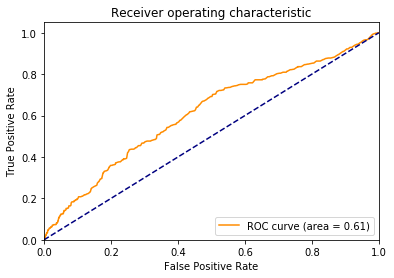

In [165]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [150]:
probs_df = pd.DataFrame(probs)

In [151]:
probs_df

,0,1
0,0.984186,0.015814
1,0.965264,0.034736
2,0.976259,0.023741
3,0.986505,0.013495
4,0.986038,0.013962
5,0.956301,0.043699
6,0.979745,0.020255
7,0.979604,0.020396
8,0.992093,0.007907
9,0.985548,0.014452


In [51]:
X_train

,temp,precipitation,overcast,poor_visibility,windy
7445,24.98,0,1,0,0
18992,44.96,0,1,1,0
63168,39.02,0,0,0,0
4169,55.04,0,1,0,0
70370,46.04,0,0,0,0
12010,44.96,0,1,1,0
2033,30.02,0,0,0,0
15984,28.04,1,1,1,0
4785,69.98,0,0,0,0
82568,30.00,1,1,0,0


In [53]:
y_train.unique()

array([0, 1])

In [87]:
X_test

,temp,precipitation,overcast,poor_visibility,windy
32361,51.98,0,0,0,0
96300,19.90,0,1,0,0
92622,39.00,0,0,0,0
5128,57.02,0,0,0,0
44394,55.94,0,0,0,0
16072,24.98,0,1,1,0
70156,44.06,1,0,0,0
5534,37.04,0,1,0,0
48935,73.94,0,0,0,0
46408,48.02,0,1,0,0


In [55]:
y_test

32361     0
96300     0
92622     0
5128      0
44394     0
16072     0
70156     0
5534      0
48935     0
46408     0
87746     0
45225     0
21343     0
83493     0
24852     0
103       0
56997     1
31448     0
91546     0
70327     0
8885      0
1125      0
86868     0
54489     0
29535     0
6852      0
16695     0
87019     0
18151     0
40392     0
         ..
33009     0
13160     0
47348     0
15356     0
104       1
12842     0
103977    0
96812     0
102154    0
54907     0
86347     0
67984     0
63733     0
19587     0
3169      0
310       0
18104     0
19152     0
7990      0
67455     0
89382     0
6135      0
70607     0
44687     0
16309     0
62190     0
96631     0
17341     0
10762     0
41081     1
Name: pass_closed, Length: 16559, dtype: int64

In [60]:
np.unique(predictions)

array([0])

In [61]:
model_df

,temp,precipitation,overcast,poor_visibility,windy,pass_closed
0,23.00,0,1,0,0,0
1,26.06,0,0,0,0,0
2,24.98,0,0,0,0,0
3,24.08,0,0,0,0,0
4,24.08,0,0,0,0,0
5,19.94,0,1,1,0,0
6,19.94,1,1,0,0,0
7,19.04,1,1,0,0,0
8,19.94,1,1,0,0,0
9,21.02,1,1,0,0,0


In [63]:
(model_df['pass_closed'] == 1).sum()

1350

In [64]:
date_column = combined_df.date

In [65]:
date_column

0        2006-12-31 23:56:00
1        2007-01-01 00:56:00
2        2007-01-01 01:56:00
3        2007-01-01 02:56:00
4        2007-01-01 03:56:00
5        2007-01-01 05:56:00
6        2007-01-01 10:56:00
7        2007-01-01 11:56:00
8        2007-01-01 12:56:00
9        2007-01-01 13:56:00
10       2007-01-01 15:56:00
11       2007-01-01 16:56:00
12       2007-01-01 19:56:00
13       2007-01-01 20:56:00
14       2007-01-01 21:56:00
15       2007-01-01 22:56:00
16       2007-01-01 23:56:00
17       2007-01-02 00:56:00
18       2007-01-02 01:56:00
19       2007-01-02 02:56:00
20       2007-01-02 03:56:00
21       2007-01-02 04:56:00
22       2007-01-02 05:56:00
23       2007-01-02 06:56:00
24       2007-01-02 07:56:00
25       2007-01-02 08:56:00
26       2007-01-02 09:56:00
27       2007-01-02 10:56:00
28       2007-01-02 11:56:00
29       2007-01-02 12:56:00
                 ...        
105403   2018-04-01 17:56:00
105411   2018-04-01 18:56:00
105418   2018-04-01 19:56:00
105426   2018-

In [66]:
month_day_of_week = pd.DataFrame({"month": date_column.dt.month, "dayofweek": date_column.dt.dayofweek})

In [68]:
model2_df = pd.concat([model_df, month_day_of_week], axis=1)

In [69]:
model2_df

,temp,precipitation,overcast,poor_visibility,windy,pass_closed,month,dayofweek
0,23.00,0,1,0,0,0,12,6
1,26.06,0,0,0,0,0,1,0
2,24.98,0,0,0,0,0,1,0
3,24.08,0,0,0,0,0,1,0
4,24.08,0,0,0,0,0,1,0
5,19.94,0,1,1,0,0,1,0
6,19.94,1,1,0,0,0,1,0
7,19.04,1,1,0,0,0,1,0
8,19.94,1,1,0,0,0,1,0
9,21.02,1,1,0,0,0,1,0


In [70]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(model2_df.drop('pass_closed',axis=1), 
                                                    model2_df['pass_closed'], test_size=0.30, 
                                                    random_state=101)

In [107]:
logmodel2 = LogisticRegression()

In [108]:
logmodel2.fit(X_train2, y_train2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [109]:
predictions2 = logmodel2.predict(X_test2)

In [110]:
print(classification_report(y_test2,predictions2))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99     16150
          1       0.00      0.00      0.00       409

avg / total       0.95      0.98      0.96     16559



/Users/leanne/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [111]:
np.unique(predictions2)

array([0])

In [112]:
probs2 = logmodel2.predict_proba(X_test2)

In [130]:
probs2

array([[0.98385941, 0.01614059],
       [0.97204121, 0.02795879],
       [0.98199384, 0.01800616],
       ...,
       [0.98696942, 0.01303058],
       [0.97667286, 0.02332714],
       [0.96101531, 0.03898469]])

In [114]:
probs2[:,1].max()

0.17886931680350535

In [115]:
probs2[:,1].min()

0.004115788930392021

In [116]:
probs2[:,1].mean()

0.024400558257086733

In [131]:
y_test2

32361     0
96300     0
92622     0
5128      0
44394     0
16072     0
70156     0
5534      0
48935     0
46408     0
87746     0
45225     0
21343     0
83493     0
24852     0
103       0
56997     1
31448     0
91546     0
70327     0
8885      0
1125      0
86868     0
54489     0
29535     0
6852      0
16695     0
87019     0
18151     0
40392     0
         ..
33009     0
13160     0
47348     0
15356     0
104       1
12842     0
103977    0
96812     0
102154    0
54907     0
86347     0
67984     0
63733     0
19587     0
3169      0
310       0
18104     0
19152     0
7990      0
67455     0
89382     0
6135      0
70607     0
44687     0
16309     0
62190     0
96631     0
17341     0
10762     0
41081     1
Name: pass_closed, Length: 16559, dtype: int64

In [146]:
log_loss2 = log_loss(y_test2, probs2)

In [147]:
log_loss2

0.11393664559609276

In [166]:
fpr, tpr, thresholds = roc_curve(y_test2, probs2[:,1])

In [167]:
roc_auc = auc(fpr, tpr)

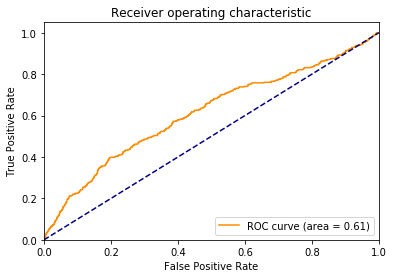

In [168]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [152]:
probs2_df = pd.DataFrame(probs2)

In [154]:
probs2_df

,0,1
0,0.983859,0.016141
1,0.972041,0.027959
2,0.981994,0.018006
3,0.987565,0.012435
4,0.983628,0.016372
5,0.955176,0.044824
6,0.982465,0.017535
7,0.980289,0.019711
8,0.991448,0.008552
9,0.987127,0.012873


In [75]:
summer_months = [5,6,7,8,9,10]
model3_df = model2_df[~model2_df.month.isin(summer_months)]

In [76]:
model3_df

,temp,precipitation,overcast,poor_visibility,windy,pass_closed,month,dayofweek
0,23.00,0,1,0,0,0,12,6
1,26.06,0,0,0,0,0,1,0
2,24.98,0,0,0,0,0,1,0
3,24.08,0,0,0,0,0,1,0
4,24.08,0,0,0,0,0,1,0
5,19.94,0,1,1,0,0,1,0
6,19.94,1,1,0,0,0,1,0
7,19.04,1,1,0,0,0,1,0
8,19.94,1,1,0,0,0,1,0
9,21.02,1,1,0,0,0,1,0


In [77]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(model3_df.drop('pass_closed',axis=1), 
                                                    model3_df['pass_closed'], test_size=0.30, 
                                                    random_state=101)

In [117]:
logmodel3 = LogisticRegression()

In [118]:
logmodel3.fit(X_train3, y_train3)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [119]:
predictions3 = logmodel3.predict(X_test3)

In [120]:
print(classification_report(y_test3,predictions3))

             precision    recall  f1-score   support

          0       0.96      1.00      0.98      7270
          1       0.00      0.00      0.00       281

avg / total       0.93      0.96      0.94      7551



/Users/leanne/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [81]:
np.unique(predictions3)

array([0])

In [82]:
(model3_df['pass_closed'] == 1).sum()

859

In [121]:
probs3 = logmodel3.predict_proba(X_test3)

In [122]:
probs3

array([[0.95112143, 0.04887857],
       [0.96689881, 0.03310119],
       [0.95447604, 0.04552396],
       ...,
       [0.97661711, 0.02338289],
       [0.97725835, 0.02274165],
       [0.98920601, 0.01079399]])

In [123]:
probs3[:,1].max()

0.2443234639244722

In [124]:
probs3[:,1].min()

0.0015913863476944123

In [125]:
probs3[:,1].mean()

0.032667421869722914

In [148]:
log_loss3 = log_loss(y_test3, probs3)

In [149]:
log_loss3

0.1526202657001886

In [169]:
fpr3, tpr3, thresholds3 = roc_curve(y_test3, probs3[:,1])

In [170]:
roc_auc3 = auc(fpr3, tpr3)

In [155]:
probs3_df = pd.DataFrame(probs3)

In [156]:
probs3_df

,0,1
0,0.951121,0.048879
1,0.966899,0.033101
2,0.954476,0.045524
3,0.976477,0.023523
4,0.977246,0.022754
5,0.991299,0.008701
6,0.968067,0.031933
7,0.961427,0.038573
8,0.971930,0.028070
9,0.968388,0.031612
